In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, f1_score, mean_squared_error
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
!pip install shap
import shap

In [2]:
#Load the dataset
df = pd.read_csv('C:/.../model_df.csv')

In [3]:
#Label Encoding
label_encoder_success = LabelEncoder()
label_encoder_weekday = LabelEncoder()
label_encoder_PSP = LabelEncoder()
label_encoder_3D_secured = LabelEncoder()
label_encoder_card = LabelEncoder()
label_encoder_unique_transaction = LabelEncoder()

df['weekday_encoded'] = label_encoder_weekday.fit_transform(df['weekday'])
df['success_encoded'] = label_encoder_success.fit_transform(df['success'])
df['PSP_encoded'] = label_encoder_PSP.fit_transform(df['PSP'])
df['3D_secured_encoded'] = label_encoder_3D_secured.fit_transform(df['3D_secured'])
df['card_encoded'] = label_encoder_card.fit_transform(df['card'])
df['unique_transaction_encoded'] = label_encoder_unique_transaction.fit_transform(df['unique_transaction'])

In [4]:
#Significant independent variables according to the Chi-square results 
X = df.loc[:, ['PSP_encoded', '3D_secured_encoded', 'card_encoded', 'unique_transaction_encoded', 'weekday_encoded', 'amount']]
y = df['success_encoded']

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 98%|===================| 9805/10051 [00:12<00:00]        

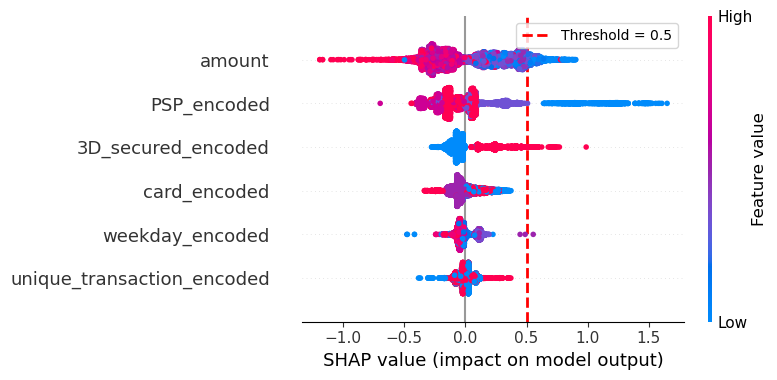

In [11]:
# Define the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.2, max_depth=3, subsample=1.0)
gb.fit(X_train, y_train)
y_train_pred_gb = gb.predict(X_train)
y_test_pred_gb = gb.predict(X_test)
threshold = 0.5
# Generate the SHAP summary plot
explainer = shap.Explainer(gb, X_train)
shap_values_gb = explainer(X_test)
shap.summary_plot(shap_values_gb, X_test, show=False)
# Overlay the decision threshold on the summary plot
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')
plt.legend()
plt.show()

In [12]:
#Important features according to SHAP
X_new = df.loc[:, ['PSP_encoded', '3D_secured_encoded','weekday_encoded', 'amount']]
X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [13]:
# Define the GradientBoostingClassifier according to SHAP
gb = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.2, max_depth=3, subsample=1.0)
gb.fit(X_new_train, y_train)
y_train_pred_gb = gb.predict(X_new_train)
y_test_pred_gb = gb.predict(X_new_test)

In [14]:
# Prediction probabilities
y_test_pred_proba_gb = gb.predict_proba(X_new_test)
# Print test prediction probabilities (only success probabilities)
success_probabilities = y_test_pred_proba_gb[:, 0]
print("Test Success Probabilities:")
print(success_probabilities)

Test Success Probabilities:
[0.75733831 0.83330285 0.89485049 ... 0.85949642 0.83283014 0.69752812]


In [15]:
# Train accuracy, F1 score, Precision, RMSE
y_train_pred_gb = gb.predict(X_new_train)
train_accuracy = accuracy_score(y_train, y_train_pred_gb)
# Test accuracy, F1 score, Precision, RMSE
test_accuracy = accuracy_score(y_test, y_test_pred_gb)

# Cross-validation (using 10-fold CV as an example)
cv_accuracy = np.mean(cross_val_score(gb, X_new_train, y_train, cv=10, scoring='accuracy'))
cv_f1 = np.mean(cross_val_score(gb, X_new_train, y_train, cv=10, scoring='f1_weighted'))
cv_precision = np.mean(cross_val_score(gb, X_new_train, y_train, cv=10, scoring='precision_weighted'))
y_cv_pred = cross_val_predict(gb, X_new_train, y_train, cv=10)
cv_rmse = np.sqrt(mean_squared_error(y_train, y_cv_pred))

# Print the results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"CV Accuracy: {cv_accuracy:.4f}")
print(f"CV F1 Score: {cv_f1:.4f}")
print(f"CV Precision: {cv_precision:.4f}")
print(f"CV RMSE: {cv_rmse:.4f}")

Train Accuracy: 0.8009
Test Accuracy: 0.7974
CV Accuracy: 0.7992
CV F1 Score: 0.7237
CV Precision: 0.7534
CV RMSE: 0.4481
